In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
# === FUNGSI-FUNGSI PEMBERSIH ===
def muat_dan_bersihkan_rasio(path_file):
    df = pd.read_csv(path_file, skiprows=3, header=None, delimiter=';')
    df.columns = ['No', 'Kode_Kem', 'Kode_BPS', 'Provinsi', 'Rasio']
    df_bersih = df[['Provinsi', 'Rasio']].copy()
    df_bersih['Rasio'] = pd.to_numeric(df_bersih['Rasio'], errors='coerce')
    return df_bersih

def muat_dan_bersihkan_internet_sekolah(path_file):
    df = pd.read_csv(path_file, skiprows=3, header=None, delimiter=';')
    df.columns = ['No', 'Kode_Kem', 'Kode_BPS', 'Provinsi', 'Tersedia', 'Tidak_Tersedia', 'Persentase_Tersedia']
    df_bersih = df[['Provinsi', 'Persentase_Tersedia']].copy()
    df_bersih = df_bersih.rename(columns={'Persentase_Tersedia': 'Persen_Internet_Sekolah'})
    df_bersih['Persen_Internet_Sekolah'] = pd.to_numeric(df_bersih['Persen_Internet_Sekolah'].str.replace(',', '.'), errors='coerce')
    return df_bersih

print("✅ Fungsi pembersih siap.")

✅ Fungsi pembersih siap.


In [ ]:
# === MEMUAT SEMUA DATA ===
try:
    df_internet_sd = muat_dan_bersihkan_internet_sekolah('/content/data/akses_internet_SD_2023.csv')
    df_internet_smp = muat_dan_bersihkan_internet_sekolah('/content/data/akses_internet_SMP_2023.csv')
    df_internet_sma = muat_dan_bersihkan_internet_sekolah('/content/data/akses_internet_SMA_2023.csv')
    df_internet_smk = muat_dan_bersihkan_internet_sekolah('/content/data/akses_internet_SMK_2023.csv')

    df_rasio_sd = muat_dan_bersihkan_rasio('/content/data/rasio_murid_guru_SD_2023.csv')
    df_rasio_smp = muat_dan_bersihkan_rasio('/content/data/rasio_murid_guru_SMP_2023.csv')
    df_rasio_sma = muat_dan_bersihkan_rasio('/content/data/rasio_murid_guru_SMA_2023.csv')
    df_rasio_smk = muat_dan_bersihkan_rasio('/content/data/rasio_murid_guru_SMK_2023.csv')

    df_internet_rt = pd.read_csv('/content/data/persentase_akses_internet_rt_2023.csv', delimiter=';', skiprows=2)
    df_internet_rt = df_internet_rt[['Unnamed: 0', 'Perkotaan+Perdesaan']].copy()
    df_internet_rt.rename(columns={'Unnamed: 0': 'Provinsi', 'Perkotaan+Perdesaan': 'Persen_Internet_RT'}, inplace=True)
    df_internet_rt['Persen_Internet_RT'] = pd.to_numeric(df_internet_rt['Persen_Internet_RT'].str.replace(',', '.'), errors='coerce')

    print("✅ Semua data berhasil dimuat.")

    # === MENGGABUNGKAN DAN STANDARDISASI ===
    df_rasio_all = pd.concat([df_rasio_sd, df_rasio_smp, df_rasio_sma, df_rasio_smk])
    df_internet_sekolah_all = pd.concat([df_internet_sd, df_internet_smp, df_internet_sma, df_internet_smk])

    df_rasio_rerata = df_rasio_all.groupby('Provinsi')['Rasio'].mean().reset_index()
    df_internet_sekolah_rerata = df_internet_sekolah_all.groupby('Provinsi')['Persen_Internet_Sekolah'].mean().reset_index()

    # === LANGKAH STANDARDISASI FINAL ===
    # Buat fungsi untuk membersihkan semua variasi nama provinsi
    def standardize_province_names(df):
        df_copy = df.copy()
        prov_col = 'Provinsi'
        # Hapus spasi ekstra & ubah ke huruf besar
        df_copy[prov_col] = df_copy[prov_col].str.strip().str.upper()
        # Hapus tanda baca
        df_copy[prov_col] = df_copy[prov_col].str.replace('.', '', regex=False)
        # Standardisasi singkatan
        df_copy[prov_col] = df_copy[prov_col].str.replace('KEP ', 'KEPULAUAN ', regex=False)
        df_copy.loc[df_copy[prov_col].str.contains('BANGKA BELITUNG', na=False), prov_col] = 'KEPULAUAN BANGKA BELITUNG'
        # Hapus baris yang tidak relevan
        df_copy = df_copy[~df_copy[prov_col].isin(['INDONESIA', 'LUAR NEGERI'])]
        return df_copy

    # Terapkan fungsi standardisasi ke setiap tabel sebelum digabung
    df_internet_rt_clean = standardize_province_names(df_internet_rt)
    df_rasio_rerata_clean = standardize_province_names(df_rasio_rerata)
    df_internet_sekolah_rerata_clean = standardize_province_names(df_internet_sekolah_rerata)

    # Lanjutkan proses merge dengan data yang sudah 100% seragam
    df_master = pd.merge(df_internet_rt_clean, df_rasio_rerata_clean, on='Provinsi')
    df_master = pd.merge(df_master, df_internet_sekolah_rerata_clean, on='Provinsi')
    df_master.dropna(inplace=True)

    print("\n✅ Tabel Master berhasil dibuat dengan benar!")
    print("Jumlah provinsi yang berhasil digabung:", len(df_master))
    print("\n5 baris pertama dari Tabel Master:")
    print(df_master.head())

except Exception as e:
    print(f"\n❌ ERROR: Terjadi kesalahan! Pesan errornya adalah: {e}")

✅ Semua data berhasil dimuat.

✅ Tabel Master berhasil dibuat dengan benar!
Jumlah provinsi yang berhasil digabung: 34

5 baris pertama dari Tabel Master:
         Provinsi  Persen_Internet_RT  Rasio  Persen_Internet_Sekolah
0            ACEH               86.46   9.50                  91.7175
1  SUMATERA UTARA               89.66  15.50                  90.7325
2  SUMATERA BARAT               89.92  13.00                  92.4300
3            RIAU               93.25  14.00                  94.3000
4           JAMBI               89.52  12.75                  92.3950


In [ ]:
# === LANGKAH 3A: MENERAPKAN AI (K-MEANS CLUSTERING) ===

# Pilih data yang akan digunakan untuk pengelompokan
features = df_master[['Persen_Internet_RT', 'Rasio']]

# Membuat model K-Means untuk membagi data menjadi 3 kelompok (cluster)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Terapkan model ke data dan tambahkan hasilnya ke Tabel Master
df_master['Cluster'] = kmeans.fit_predict(features)

print("✅ Analisis AI (Clustering) selesai. Setiap provinsi sudah diberi label cluster.")
print("Contoh data setelah ditambahkan cluster:")
print(df_master.head())

✅ Analisis AI (Clustering) selesai. Setiap provinsi sudah diberi label cluster.
Contoh data setelah ditambahkan cluster:
         Provinsi  Persen_Internet_RT  Rasio  Persen_Internet_Sekolah  Cluster
0            ACEH               86.46   9.50                  91.7175        2
1  SUMATERA UTARA               89.66  15.50                  90.7325        0
2  SUMATERA BARAT               89.92  13.00                  92.4300        0
3            RIAU               93.25  14.00                  94.3000        0
4           JAMBI               89.52  12.75                  92.3950        0



✅ Visualisasi final berhasil dibuat dan disimpan sebagai 'hasil_akhir_clustering.png'.


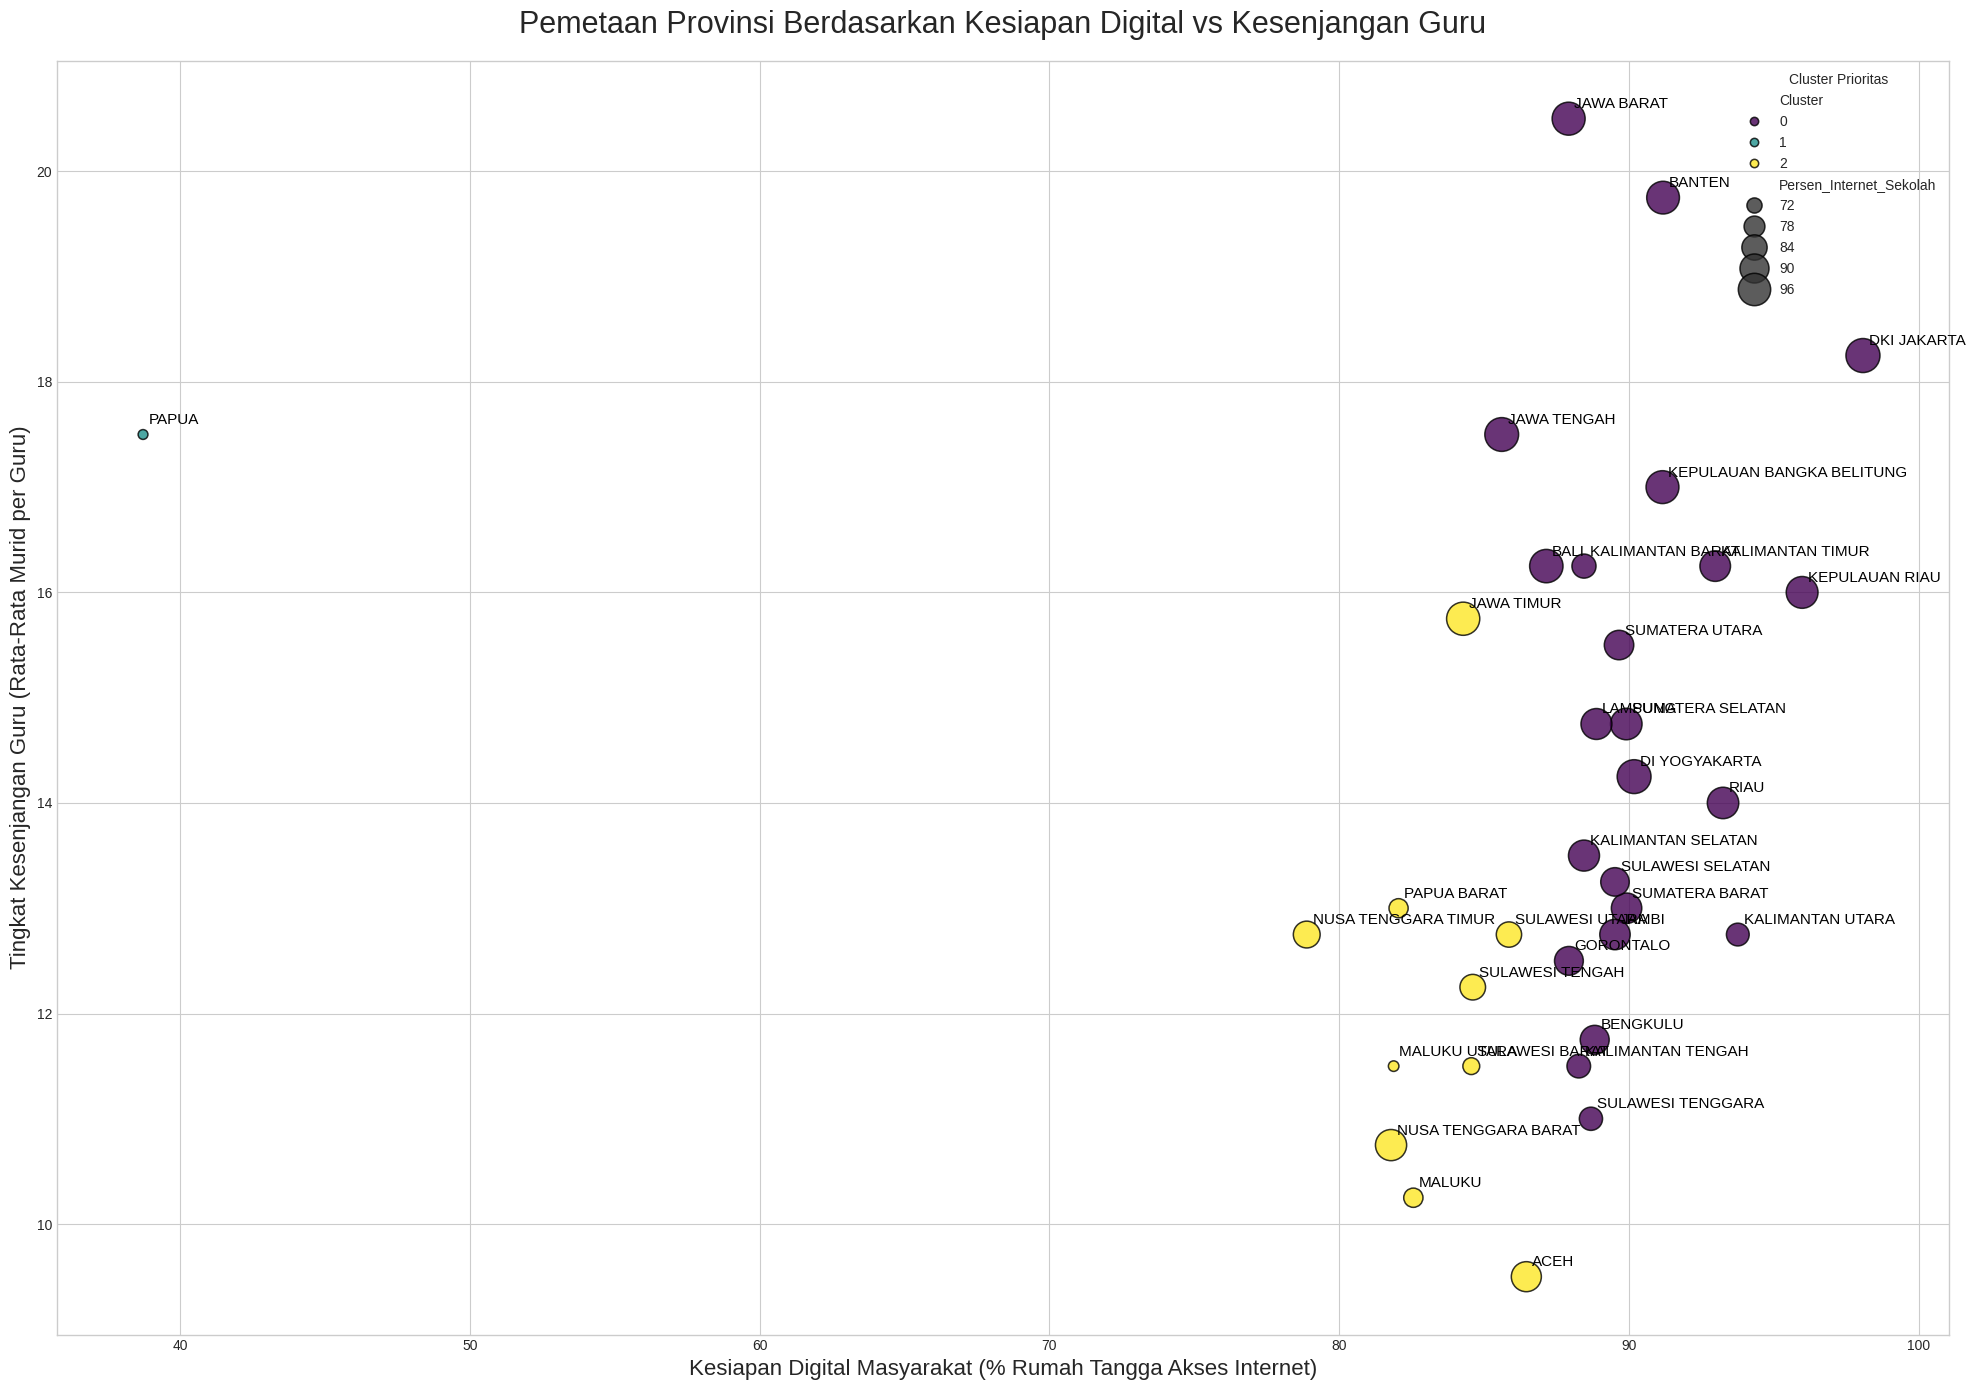

In [ ]:
# === LANGKAH 3B: VISUALISASI HASIL CLUSTER ===

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(20, 14))

# Membuat scatter plot dengan warna berdasarkan kolom 'Cluster'
plot = sns.scatterplot(
    data=df_master,
    x='Persen_Internet_RT',
    y='Rasio',
    hue='Cluster',
    palette='viridis',
    size='Persen_Internet_Sekolah', # <-- Menggunakan ukuran
    sizes=(50, 600), # <-- Mengatur rentang ukuran titik
    alpha=0.8,
    edgecolor='black'
)

# Menambahkan label nama provinsi di setiap titik
for i in range(df_master.shape[0]):
    plt.text(x=df_master['Persen_Internet_RT'].iloc[i] + 0.2,
             y=df_master['Rasio'].iloc[i] + 0.1,
             s=df_master['Provinsi'].iloc[i],
             fontdict=dict(color='black', size=11))

plt.title('Pemetaan Provinsi Berdasarkan Kesiapan Digital vs Kesenjangan Guru', fontsize=22, pad=20)
plt.xlabel('Kesiapan Digital Masyarakat (% Rumah Tangga Akses Internet)', fontsize=16)
plt.ylabel('Tingkat Kesenjangan Guru (Rata-Rata Murid per Guru)', fontsize=16)
plt.legend(title='Cluster Prioritas')
plt.tight_layout()

# Simpan hasil visualisasi ke file gambar
plt.savefig('hasil_akhir_clustering.png', dpi=300)

print("\n✅ Visualisasi final berhasil dibuat dan disimpan sebagai 'hasil_akhir_clustering.png'.")

In [ ]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# === SETUP API DAN MODEL ===
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [ ]:
# === MENGANALISIS SETIAP CLUSTER DENGAN AI ===

# Cek apakah model 'output' berhasil dibuat
if 'output' in locals():
    print("\nMemulai proses interpretasi dengan AI untuk setiap cluster...")
    print("="*60)

    for cluster_id in sorted(df_master['Cluster'].unique()):
        cluster_data = df_master[df_master['Cluster'] == cluster_id]

        avg_internet_rt = cluster_data['Persen_Internet_RT'].mean()
        avg_rasio = cluster_data['Rasio'].mean()
        list_provinsi = ", ".join(cluster_data['Provinsi'].tolist())

        konteks = f"""
        Data untuk Cluster {cluster_id}:
        - Anggota Provinsi: {list_provinsi}
        - Rata-rata Persentase Akses Internet Rumah Tangga: {avg_internet_rt:.2f}%
        - Rata-rata Rasio Murid per Guru: {avg_rasio:.2f}
        """

        prompt = f"""
        Anda adalah seorang analis kebijakan pendidikan ahli untuk pemerintah Indonesia.
        Berdasarkan data berikut, berikan analisis singkat dan tajam.

        Konteks Data:
        {konteks}

        Tugas Anda:
        1.  **Nama Cluster & Interpretasi**: Berikan nama yang deskriptif untuk cluster ini dan jelaskan karakteristik utamanya dalam satu kalimat.
        2.  **Insight Utama**: Apa satu wawasan (insight) paling penting yang bisa kita pelajari dari kelompok provinsi ini?
        3.  **Rekomendasi Kebijakan**: Berikan SATU rekomendasi kebijakan yang paling konkret dan actionable untuk cluster ini.
        """

        print(f"\n⏳ Menganalisis Cluster {cluster_id}...")

        # Panggil model AI menggunakan variabel 'output'
        response = output.invoke(prompt)

        print(f"--- HASIL ANALISIS AI UNTUK CLUSTER {cluster_id} ---")
        print(response)
        print("="*60)


Memulai proses interpretasi dengan AI untuk setiap cluster...

⏳ Menganalisis Cluster 0...
--- HASIL ANALISIS AI UNTUK CLUSTER 0 ---
1. **Nama Cluster & Interpretasi**: Nama deskriptif untuk cluster ini adalah "Cluster Pendidikan Tinggi di Sumatera dan Java". Karakteristik utamanya adalah daerah-daerah dengan rasio murid-guru yang relatif rendah dan akses internet rumah tangga yang tinggi.

2. **Insight Utama**: Insight utama dari cluster ini adalah adanya ketersediaan akses internet yang tinggi dan rasio murid-guru yang relatif rendah, yang mungkin menunjukkan potensi untuk integrasi teknologi dalam pendidikan dan kebutuhan untuk optimasi penggunaan sumber guru di daerah-daerah ini.

3. **Rekomendasi Kebijakan**: Rekomendasi kebijakan konkret dan actionable untuk cluster ini adalah mendorong pengembangan program "Pendidikan Muda" yang menggunakan teknologi. Program ini dapat melibatkan penggunaan e-learning, webinar, dan platform online untuk guru-guru mengikuti pelatihan dan pengemb